In [106]:
!pip3 install pandas
!pip3 install numpy
!pip3 install scikit-learn
!pip3 install matplotlib
!pip3 install seaborn

You should consider upgrading via the 'c:\users\alexd\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\alexd\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\alexd\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\alexd\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\alexd\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


Importaciones

In [107]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Carga de los datos y filtrado

In [108]:
wind_ava = pd.read_csv('wind_ava.csv.gz', compression="gzip")

# Apartado 1
EDA o Análisis Exploratorio de los Datos

In [109]:
# Elimina todas las variables meteorológicas que no correspondan a la localización de Sotavento (la localización 13)
wind_ava = wind_ava.filter(regex='^(datetime|energy|.*\.13)$')

# Número de instancias y características
print(f'Número de instancias: {wind_ava.shape[0]}')
print(f'Número de características: {wind_ava.shape[1]}')

# Variables categóricas y numéricas
categorical_vars = wind_ava.select_dtypes(include=['object']).columns
numerical_vars = wind_ava.select_dtypes(include=['int64', 'float64']).columns
print(f'Variables categóricas: {categorical_vars}')
print(f'Variables numéricas: {numerical_vars}')

# Comprueba si hay valores faltantes y qué variables los tienen
missing_values = wind_ava.isnull().sum()
print(f'Valores faltantes por variable:\n{missing_values[missing_values > 0]}')

# Columnas constantes
constant_columns = [col for col in wind_ava.columns if wind_ava[col].nunique() <= 1]
print(f'Columnas constantes: {constant_columns}')

# Elimina las columnas constantes
wind_ava = wind_ava.loc[:, wind_ava.apply(pd.Series.nunique) != 1]

# Determinar si es un problema de regresión o clasificación
if wind_ava['energy'].nunique() > 2:
    print('Es un problema de regresión')
else:
    print('Es un problema de clasificación')


Número de instancias: 4748
Número de características: 24
Variables categóricas: Index(['datetime'], dtype='object')
Variables numéricas: Index(['energy', 'p54.162.13', 'p55.162.13', 'cape.13', 'p59.162.13',
       'lai_lv.13', 'lai_hv.13', 'u10n.13', 'v10n.13', 'sp.13', 'stl1.13',
       'u10.13', 'v10.13', 't2m.13', 'stl2.13', 'stl3.13', 'iews.13',
       'inss.13', 'stl4.13', 'fsr.13', 'flsr.13', 'u100.13', 'v100.13'],
      dtype='object')
Valores faltantes por variable:
Series([], dtype: int64)
Columnas constantes: []
Es un problema de regresión


### Matriz de correlación
Podemos realizar una matriz de correlación para ver que variables están fuertemente relacionadas

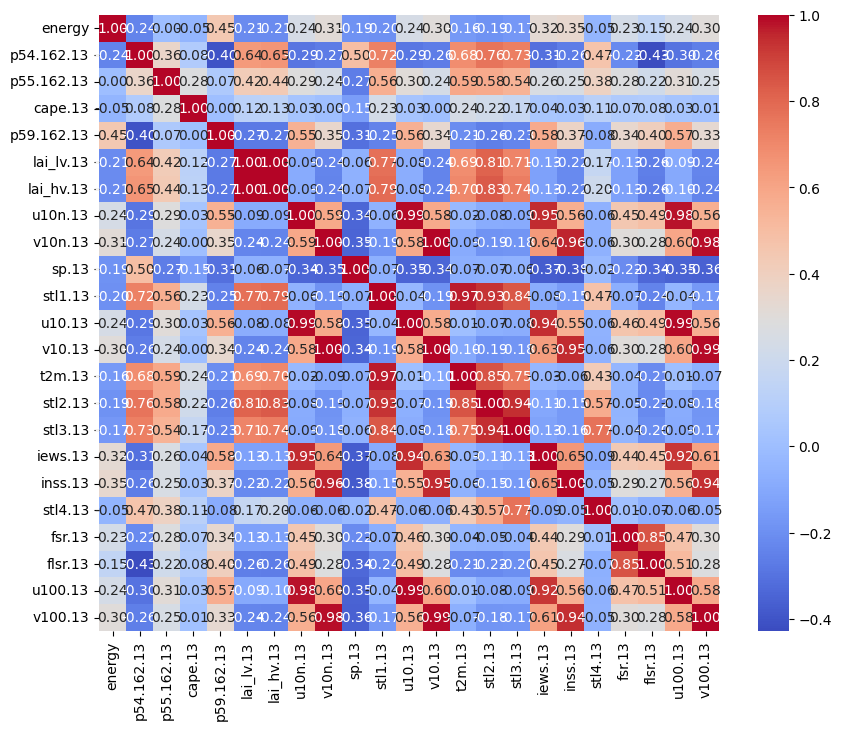

In [110]:
# Realizamos un analisis de la correlación de las variables númericas
correlation = wind_ava[numerical_vars].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

Con estos resultados podemos ver que tanto las variables `` lai_lv.13`` y `` lai_hv.13 ``, como las variables `` v10.13 `` y `` v10n.13``, tienen una correlacion de 1. Por lo tanto, podemos quitar una de cada pareja, ya que dan información redundante.

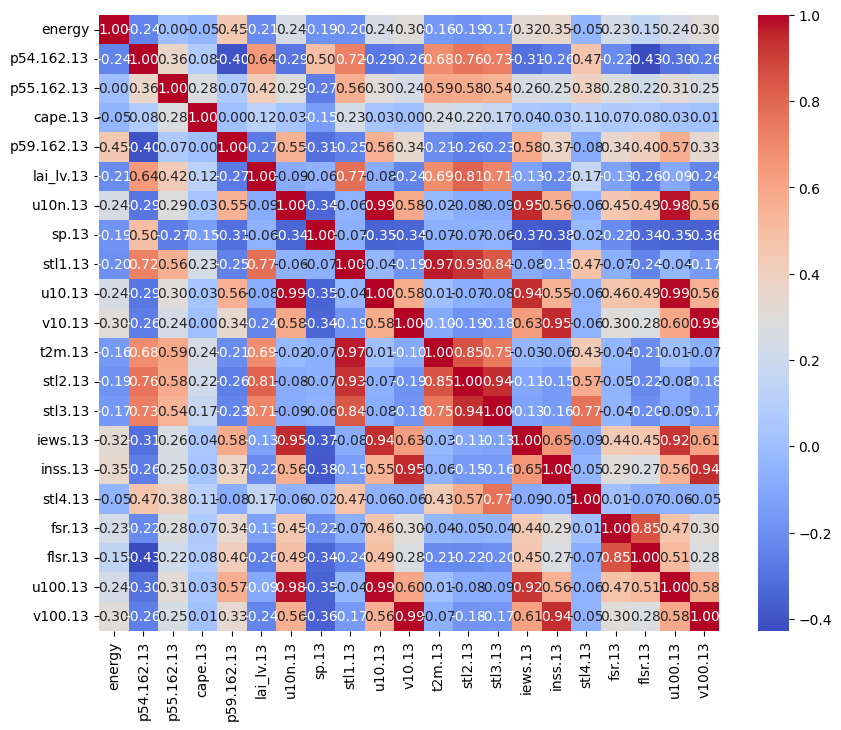

In [111]:
# Elimina las variables 'lai_hv.13' y 'v10n.13'
if 'lai_hv.13' in wind_ava.columns and 'v10n.13' in wind_ava.columns:
    wind_ava = wind_ava.drop(['lai_hv.13', 'v10n.13'], axis=1)

# Vuelve a definir las variables numéricas
numerical_vars = wind_ava.select_dtypes(include=['int64', 'float64']).columns

# Realizamos un analisis de la correlación de las variables númericas
correlation = wind_ava[numerical_vars].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

Podemos observar que sigue habiendo variables muy correlacionadas entre ellas, llegando a haber resultados de 0.99, pero en ningún caso aparece un 1 fuera de la diagonal. Además, con esta matriz podemos ver que la variable que más correlación tiene con la energía producida es `` p59.162 `` (Vertical integral of divergence of kinetic energy) con un grado casi del 50%.


# Apartado 2
La evaluación ``outer`` del modelo se llevará a cabo por medio de la evualuación train/test, ya que disponemos de un gran número de datos. Por otro lado, en la evaluavión ``inner`` se utilizará más de un método de evaluación con el fin de probarlos y comparar sus resultados. Esto incluye train/test, evaluación cruzada, y el uso de Grid-search (para ajustar múltiples hiperparámetros)

# Apartado 3
En primer lugar, y usando el método KNN, vamos a comprobar cuál es el mejor método de escalado para nuestros datos. Para ello nos vamos a basar en el error cuadrático medio negativo (o RMSE), por lo que el modelo con el resultado más pequeño será el modelo más preciso

In [112]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# Dividir los datos en conjuntos de entrenamiento y prueba (evaluación externa)
X_train, X_test, y_train, y_test = train_test_split(wind_ava[numerical_vars], wind_ava['energy'], test_size=1/3, random_state=100472166, shuffle=False)

# Definir los métodos de escalado para evaluar
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

# Evauluación interna con 3-fold time series cross-validation
inner = TimeSeriesSplit(n_splits=3)

# Diccionario para almacenar los resultados de la evaluación interna
inner_scores = {}

# Pipeline para StandardScaler
knn_standard = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor())
])

scores_std = cross_val_score(knn_standard, X_train, y_train, cv=inner, scoring='neg_root_mean_squared_error')
inner_scores['StandardScaler'] = -scores_std.mean()

# Pipeline para MinMaxScaler
knn_minmax = Pipeline([
    ('scaler', MinMaxScaler()),
    ('knn', KNeighborsRegressor())
])
scores_minmax = cross_val_score(knn_minmax, X_train, y_train, cv=inner, scoring='neg_root_mean_squared_error')
inner_scores['MinMaxScaler'] = -scores_minmax.mean()

# Pipeline para RobustScaler
knn_robust = Pipeline([
    ('scaler', RobustScaler()),
    ('knn', KNeighborsRegressor())
])
scores_robust = cross_val_score(knn_robust, X_train, y_train, cv=inner, scoring='neg_root_mean_squared_error')
inner_scores['RobustScaker'] = -scores_robust.mean()

# Imprimimos los resultados
for scaler_name, score in inner_scores.items():
    print(f"Variable Name: {scaler_name}")
    print(f"Variable Score: {score}")
    print()

# Elegimos el mejor método de escalado según el RMSE
mejor_scaler = min(inner_scores, key=inner_scores.get)
print(f"El mejor método de escalado es {mejor_scaler} con un RMSE de {inner_scores[min(inner_scores, key=inner_scores.get)]}")

Variable Name: StandardScaler
Variable Score: 260.9618943366018

Variable Name: MinMaxScaler
Variable Score: 226.5515948126089

Variable Name: RobustScaker
Variable Score: 308.4120037902232

El mejor método de escalado es MinMaxScaler con un RMSE de 226.5515948126089


# Apartado 4
De manera similar, ahora evaluaremos y mediremos los tiempos de distintos métodos. Primero lo haremos con sus hiperparámetros por defecto, como se muestra a continuación

In [113]:
import time
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor

# Crear instancias de los modelos
knn = KNeighborsRegressor()
tree = DecisionTreeRegressor()
linear = LinearRegression()
lasso = Lasso()
svm = SVR()
dummy = DummyRegressor(strategy='mean')

# Crear listas para almacenar los tiempos de entrenamiento y los errores
times = {name: [] for name in scalers}
errors = {name: [] for name in scalers}

models = [knn, tree, linear, lasso, svm, dummy]
model_names = ['KNN', 'Árboles de Regresión', 'Regresión Lineal', 'Regresión Lasso', 'SVM', 'Dummy']

# Entrenar y evaluar los modelos con diferentes métodos de escalado
for scaler_name, scaler in scalers.items():
    if scaler is not None:
        # Escalar los datos de entrenamiento
        X_train_scaled = scaler.fit_transform(X_train)
        # Escalar los datos de prueba
        X_test_scaled = scaler.transform(X_test)
    else:
        # Si no se utiliza escalado, usar los datos originales
        X_train_scaled = X_train
        X_test_scaled = X_test

    for model, name in zip(models, model_names):
        start_time = time.time()
        model.fit(X_train_scaled, y_train)
        end_time = time.time()
        train_time = end_time - start_time
        times[scaler_name].append(train_time)

        y_pred = model.predict(X_test_scaled)
        error = mean_squared_error(y_test, y_pred)
        errors[scaler_name].append(error)

        print(f"Modelo: {name}, Escalado: {scaler_name}")
        print(f"Tiempo de entrenamiento: {train_time} segundos")
        print(f"Error cuadrático medio: {error}")
        print("------------------------")

Modelo: KNN, Escalado: StandardScaler
Tiempo de entrenamiento: 0.003999948501586914 segundos
Error cuadrático medio: 59005.56796459635
------------------------
Modelo: Árboles de Regresión, Escalado: StandardScaler
Tiempo de entrenamiento: 0.23616981506347656 segundos
Error cuadrático medio: 12.310969298799817
------------------------
Modelo: Regresión Lineal, Escalado: StandardScaler
Tiempo de entrenamiento: 0.020018815994262695 segundos
Error cuadrático medio: 8.549122927302392e-25
------------------------
Modelo: Regresión Lasso, Escalado: StandardScaler
Tiempo de entrenamiento: 0.008026123046875 segundos
Error cuadrático medio: 1.0079751638523466
------------------------
Modelo: SVM, Escalado: StandardScaler
Tiempo de entrenamiento: 0.4808623790740967 segundos
Error cuadrático medio: 378740.7156754058
------------------------
Modelo: Dummy, Escalado: StandardScaler
Tiempo de entrenamiento: 0.0022504329681396484 segundos
Error cuadrático medio: 445205.9021159534
--------------------

### GridSearch
Ahora volveremos a evaluar los modelos, pero esta vez probando distintos valores para los hiperparámetros y mediante el uso de un procedimiento sistemático como ``GridSearchCV``

In [114]:
from sklearn.model_selection import GridSearchCV

# Hiperparámetros
knn_params_pipeline = {'knn__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21]}
knn_params = {'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21]}
tree_params = {'max_depth': [None, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]}
linear_params = {'fit_intercept': [True, False]}
lasso_params = {'alpha': [0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]}
svm_params = {'C': [1.0, 10.0, 100.0, 1000.0]}

# Realizamos GridSearchCV para KNN utilizando las pipelines
best_scores ={}
knn_grid_std = GridSearchCV(knn_standard, knn_params_pipeline, cv=inner, scoring='neg_root_mean_squared_error')
knn_grid_std.fit(X_train, y_train)
best_scores['StandardScaler'] = -knn_grid_std.best_score_

knn_grid_minmax = GridSearchCV(knn_minmax, knn_params_pipeline, cv=inner, scoring='neg_root_mean_squared_error')
knn_grid_minmax.fit(X_train, y_train)
best_scores['MinMaxScaler'] = -knn_grid_minmax.best_score_

knn_grid_robust = GridSearchCV(knn_robust, knn_params_pipeline, cv=inner, scoring='neg_root_mean_squared_error')
knn_grid_robust.fit(X_train, y_train)
best_scores['RobustScaler'] = -knn_grid_robust.best_score_

for scaler_name, score in best_scores.items():
    print(f"Nombre de variable: {scaler_name}")
    print(f"Puntuación: {score}")
    print()

# Realizamos GridSearchCV para cada modelo
knn_grid = GridSearchCV(KNeighborsRegressor(), knn_params)
tree_grid = GridSearchCV(DecisionTreeRegressor(), tree_params)
linear_grid = GridSearchCV(LinearRegression(), linear_params)
lasso_grid = GridSearchCV(Lasso(), lasso_params)
svm_grid = GridSearchCV(SVR(), svm_params)

# Ajusta los modelos con los mejores hiperparámetros
knn_grid.fit(X_train_scaled, y_train)
tree_grid.fit(X_train_scaled, y_train)
linear_grid.fit(X_train_scaled, y_train)
lasso_grid.fit(X_train_scaled, y_train)
svm_grid.fit(X_train_scaled, y_train)

# Obtenemos los mejores hiperparámetros y puntuaciones para cada modelo
best_knn_params = knn_grid.best_params_
best_knn_score = knn_grid.best_score_

best_tree_params = tree_grid.best_params_
best_tree_score = tree_grid.best_score_

best_linear_params = linear_grid.best_params_
best_linear_score = linear_grid.best_score_

best_lasso_params = lasso_grid.best_params_
best_lasso_score = lasso_grid.best_score_

best_svm_params = svm_grid.best_params_
best_svm_score = svm_grid.best_score_

# Imprime los resultados
print("KNN:")
print("Mejores Hiperparámetros:", best_knn_params)
print("Mejor Puntuación:", best_knn_score)
print("------------------------")

print("Árbol de Decisión:")
print("Mejores Hiperparámetros:", best_tree_params)
print("Mejor Puntuación:", best_tree_score)
print("------------------------")

print("Regresión Lineal:")
print("Mejores Hiperparámetros:", best_linear_params)
print("Mejor Puntuación:", best_linear_score)
print("------------------------")

print("Lasso:")
print("Mejores Hiperparámetros:", best_lasso_params)
print("Mejor Puntuación:", best_lasso_score)
print("------------------------")

print("SVM:")
print("Mejores Hiperparámetros:", best_svm_params)
print("Mejor Puntuación:", best_svm_score)
print("------------------------")


Nombre de variable: StandardScaler
Puntuación: 259.03177913927357

Nombre de variable: MinMaxScaler
Puntuación: 226.3162477431106

Nombre de variable: RobustScaler
Puntuación: 308.4120037902232

KNN:
Mejores Hiperparámetros: {'n_neighbors': 9}
Mejor Puntuación: 0.8223063163495145
------------------------
Árbol de Decisión:
Mejores Hiperparámetros: {'max_depth': 35}
Mejor Puntuación: 0.999945658794011
------------------------
Regresión Lineal:
Mejores Hiperparámetros: {'fit_intercept': True}
Mejor Puntuación: 1.0
------------------------
Lasso:
Mejores Hiperparámetros: {'alpha': 0.1}
Mejor Puntuación: 0.9999999529594967
------------------------
SVM:
Mejores Hiperparámetros: {'C': 1000.0}
Mejor Puntuación: 0.985235657252084
------------------------


Basándonos en los resultados obtenidos, llegamos a las siguientes conclusiones:

En términos de puntuación, la Regresión Lineal obtuvo un 1.0, lo que indica un muy buen ajuste a los datos. En cuanto a factores como la interpretación de los resultados y el rendimiento computacional la Regresión Lineal también mostraba muy buenos resultados, por lo que consideramos que es el mejor método.

En cuanto a velocidad, el método más rápido es el "Dummy" con 0.0 segundos (es decir, es un método prácticamente instantáneo para este conjunto de datos). Sin embargo, los resultados del resto de métodos son obviamente mejores que los obtenidos con un "DummyRegressor". Si bien es cierto que este tipo de regresor nos permite ahorrar tiempo, el error cuadrático medio es mucho más alto que el de los demás.

En general, existe un equilibrio entre el tiempo de ejecución y la mejora de resultados. Por ejemplo, los árboles de regresión tardan más que el método KNN, pero al mismo tiempo KNN muestra peores resultados que los árboles de regresióm. Esto en nuestro análisis de los datos no se cumple siempre de todos modos, ya que el método de regresión lineal es más rápido que varios de los demás y aun así presenta el mejor resultado.

El ajuste de hiperparámetros también ayuda a mejorar el rendimiento de los modelos en comparación con los valores por defecto. En este caso, hemos utilizado GridSearchCV para buscar los mejores hiperparámetros para cada modelo. Por ejemplo, para el método SMV y para la regresión Lasso se consideran como los mejores hiperparámetros el 100.0 y el 0.1, respectivamente. En cambio, el resto de métodos (regresión lineal, KNN y árboles de regresión).

Por último, podríamos extraer atributos relevantes dependiendo del modelo utilizado, ya que algunos (como los árboles de decisión) proporcionan información sobre la importancia de los atributos. Por ejemplo, se puede obtener la importancia de los atributos en uno de estos árboles mediante el atributo feature_importances_.

### Validación cruzada

In [115]:
from sklearn.model_selection import cross_val_score

# Definición de modelos
models = {
    'KNN': KNeighborsRegressor(),
    'Árboles de regresión': DecisionTreeRegressor(),
    'Regresión lineal': LinearRegression(),
    'Lasso': Lasso(),
    'SVM': SVR()
}

# Realiza la validación cruzada para cada modelo
for model_name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    print(f'Modelo: {model_name}')
    print(f'Puntuaciones de validación cruzada: {scores}')
    print(f'Puntuación media de validación cruzada: {scores.mean()}')
    print()


Modelo: KNN
Puntuaciones de validación cruzada: [0.79999062 0.82079556 0.86624533 0.77855063 0.83049875]
Puntuación media de validación cruzada: 0.8192161764229112

Modelo: Árboles de regresión
Puntuaciones de validación cruzada: [0.99997076 0.9997387  0.99998267 0.99997894 0.99998033]
Puntuación media de validación cruzada: 0.9999302819962409

Modelo: Regresión lineal
Puntuaciones de validación cruzada: [1. 1. 1. 1. 1.]
Puntuación media de validación cruzada: 1.0

Modelo: Lasso
Puntuaciones de validación cruzada: [0.99999552 0.99999506 0.9999951  0.99999552 0.99999529]
Puntuación media de validación cruzada: 0.9999952959496767

Modelo: SVM
Puntuaciones de validación cruzada: [-0.03794589 -0.06314537  0.07597555  0.1434655  -0.0252549 ]
Puntuación media de validación cruzada: 0.018618977111872347



Con respecto a los resultados obtenidos en la validación cruzada podemos ver que KNN tiene una media de 0.823 lo que indica un buen rendimiento. Modelos como árboles de regresión, lasso o regresión lineal nos dan una media de 1 lo que nos puede estar indicando que el modelo esta sobreajustado o está realizandolo muy bien. Mientras que SVM obtiene una puntuación negativa indicando un mal rendimiento.

# Apartado 5

En resumen, el método elegido es el de ``regresión lineal`` y la técnica de escalado es ``MinMaxScaler``. Estos serán por lo tanto los métodos que utilicemos para realizar la evalución del rendimiento futuro, como se muestra en el siguiente código:

In [116]:
from sklearn import metrics

knn_minmax.fit(X_train, y_train)
y_pred = knn_minmax.predict(X_test)
outer_score = metrics.mean_squared_error(y_test, y_pred)
print(f"Estimación de rendmineto de KNN con MinMaxScaler {outer_score}")

Estimación de rendmineto de KNN con MinMaxScaler 35903.26083486797


In [117]:
import pickle

# Carga los datos de competición en un DataFrame
competition_data = pd.read_csv('wind_comp.csv.gz', compression="gzip")

# Nos aseguramos de que 'numerical_vars' no incluye 'energy'
numerical_vars = [var for var in numerical_vars if var != 'energy']

# Ajusta el escalador a tus datos de entrenamiento
scaler = scalers[mejor_scaler]
scaler.fit(X_train[numerical_vars])

# Transforma los datos de entrenamiento y de competición con el método de escalado
X_train_scaled = scaler.transform(X_train[numerical_vars])
X_competition_scaled = scaler.transform(competition_data[numerical_vars])

# Selecciona el mejor modelo que fue la Regresión Lineal
best_model = LinearRegression()

# Entrena el modelo final con todos los datos
best_model.fit(X_train_scaled, y_train)

# Guarda el modelo final
with open('modelo_final.pkl', 'wb') as file:
    pickle.dump(best_model, file)

# Carga el modelo final
with open('modelo_final.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Utiliza el modelo final para hacer predicciones en el conjunto de datos de la competición y las guarda en un CSV
competition_predictions = loaded_model.predict(X_competition_scaled)
pd.DataFrame(competition_predictions).to_csv('predicciones.csv', index=False)
